<a href="https://colab.research.google.com/github/crlotwhite/ML_Study/blob/main/%EB%85%BC%EB%AC%B8%EA%B5%AC%ED%98%84/nlp/%5B2021%5D_FNet_Mixing_Tokens_with_Fourier_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import keras

In [16]:
import tensorflow as tf
import keras
from keras import layers
from keras import ops
import os

In [17]:
vocab_size = 8192
max_samples = 50000
buffer_size = 20000
max_length = 40
embed_dim = 256
latent_dim = 512
num_heads = 8
batch_size = 64

In [18]:
path_to_zip = keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)
path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
)
path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")


In [19]:
def load_conversations():
    # Helper function for loading the conversation splits
    id2line = {}
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        for i in range(len(conversation) - 1):
            inputs.append(id2line[conversation[i]])
            outputs.append(id2line[conversation[i + 1]])
            if len(inputs) >= max_samples:
                return inputs, outputs
    return inputs, outputs


questions, answers = load_conversations()

# Splitting training and validation sets

train_dataset = tf.data.Dataset.from_tensor_slices((questions[:40000], answers[:40000]))
val_dataset = tf.data.Dataset.from_tensor_slices((questions[40000:], answers[40000:]))

In [20]:
def preprocess_text(sentence):
    sentence = tf.strings.lower(sentence)
    # Adding a space between the punctuation and the last word to allow better tokenization
    sentence = tf.strings.regex_replace(sentence, r"([?.!,])", r" \1 ")
    # Replacing multiple continuous spaces with a single space
    sentence = tf.strings.regex_replace(sentence, r"\s\s+", " ")
    # Replacing non english words with spaces
    sentence = tf.strings.regex_replace(sentence, r"[^a-z?.!,]+", " ")
    sentence = tf.strings.strip(sentence)
    sentence = tf.strings.join(["[start]", sentence, "[end]"], separator=" ")
    return sentence


vectorizer = layers.TextVectorization(
    vocab_size,
    standardize=preprocess_text,
    output_mode="int",
    output_sequence_length=max_length,
)

# We will adapt the vectorizer to both the questions and answers
# This dataset is batched to parallelize and speed up the process
vectorizer.adapt(tf.data.Dataset.from_tensor_slices((questions + answers)).batch(128))

In [21]:
def vectorize_text(inputs, outputs):
    inputs, outputs = vectorizer(inputs), vectorizer(outputs)
    # One extra padding token to the right to match the output shape
    outputs = tf.pad(outputs, [[0, 1]])
    return (
        {"encoder_inputs": inputs, "decoder_inputs": outputs[:-1]},
        {"outputs": outputs[1:]},
    )


train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = (
    train_dataset.cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

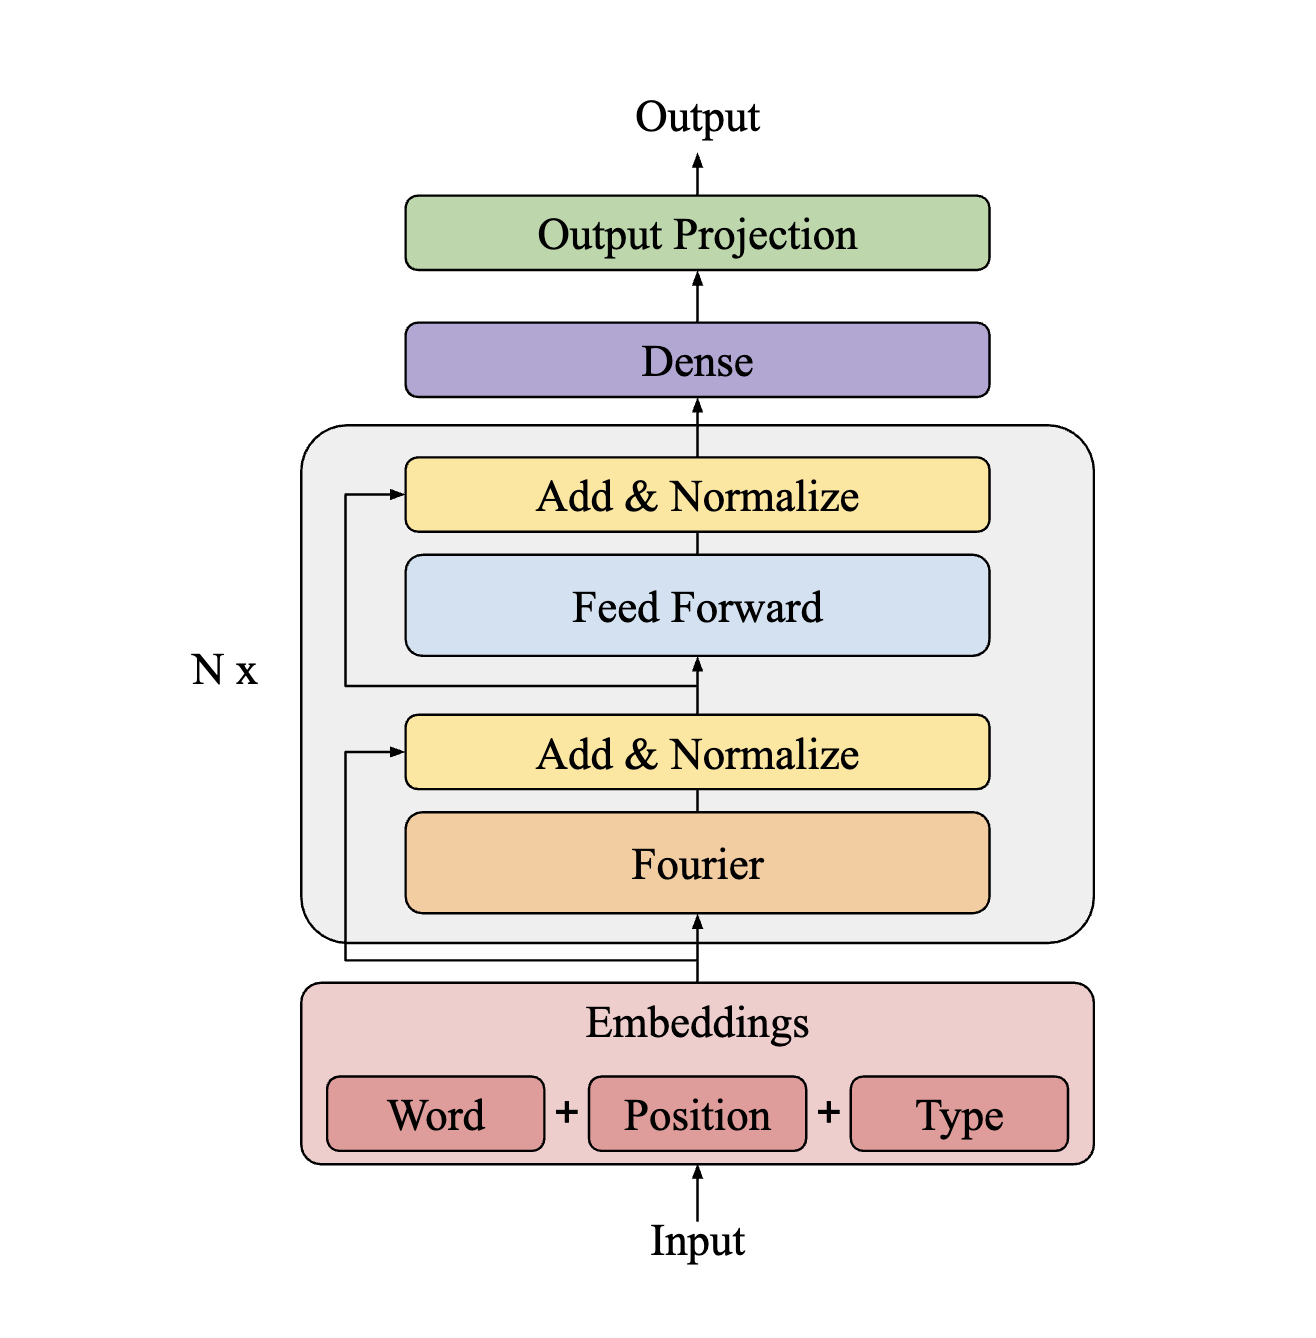

In [22]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)

        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        inp_complex = tf.cast(inputs, tf.complex64)
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)



In [23]:
# Transformer에서 봤던 그 위치 인코딩
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0) # keras 이슈로 코드 수정



In [24]:
# 기본적으로 Fnet의 의의는 어텐션을 사용하지 않고도 일정 수준의 품질에 도달한다는 것이지만,
# 참고한 구현에서는 트랜스포머의 디코더를 그대로 사용
class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(FNetDecoder, self).__init__(**kwargs)

        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = causal_mask

        attention_output_1 = self.attention_1(query=inputs,
                                              value=inputs,
                                              key=inputs,
                                              attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,
                                              value=encoder_outputs,
                                              key=encoder_outputs,
                                              attention_mask=padding_mask)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)

        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1),
                          tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)



In [25]:
def create_model():
    encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    x = PositionalEmbedding(max_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = FNetEncoder(embed_dim, latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(max_length, vocab_size, embed_dim)(decoder_inputs)
    x = FNetDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs],
                          decoder_outputs, name='outputs')

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    fnet = keras.Model([encoder_inputs, decoder_inputs],
                       decoder_outputs, name='fnet')
    return fnet

In [28]:
fnet = create_model()
fnet.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'f_net_encoder_1' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [34]:
fnet.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7228 - loss: 2.9192 - val_accuracy: 0.7613 - val_loss: 2.5378
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.7657 - loss: 2.4269 - val_accuracy: 0.7924 - val_loss: 2.1763
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - accuracy: 0.7898 - loss: 2.0820 - val_accuracy: 0.8155 - val_loss: 1.9408
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8150 - loss: 1.7701 - val_accuracy: 0.8421 - val_loss: 1.6905
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.8406 - loss: 1.4931 - val_accuracy: 0.8589 - val_loss: 1.5531
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8605 - loss: 1.2712 - val_accuracy: 0.8736 - val_loss: 1.4368
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8760 - loss: 1.0955 - val_accuracy: 0.8797 - val_loss: 1.3892
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.8863 - loss: 0.9581 - 

In [38]:
vocab = vectorizer.get_vocabulary()

def decode_sentence(input_sentence):
    tokenized_input_sentence = vectorizer(
        tf.constant("[start]" + preprocess_text(input_sentence) + "[end]"))

    tokenized_target_sentence = tf.expand_dims(vocab.index("[start]"), 0)
    decoded_sentence = ""

    for i in range(max_length):
        predictions = fnet.predict({
            "encoder_inputs": tf.expand_dims(tokenized_input_sentence, 0),
            "decoder_inputs": tf.expand_dims(
                tf.pad(tokenized_target_sentence,
                 [[0, max_length - tf.shape(tokenized_target_sentence)[0]]]), 0)
        })
        sampled_token_index = tf.argmax(predictions[0, i, :])
        sampled_token = vocab[sampled_token_index.numpy()]

        if tf.equal(sampled_token_index, vocab.index("[end]")):
            break

        decoded_sentence += sampled_token + " "
        tokenized_target_sentence = tf.concat([tokenized_target_sentence,
                                               [sampled_token_index]], 0)

    return decoded_sentence


decode_sentence("Where have you been all this time?")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

'about                                        '

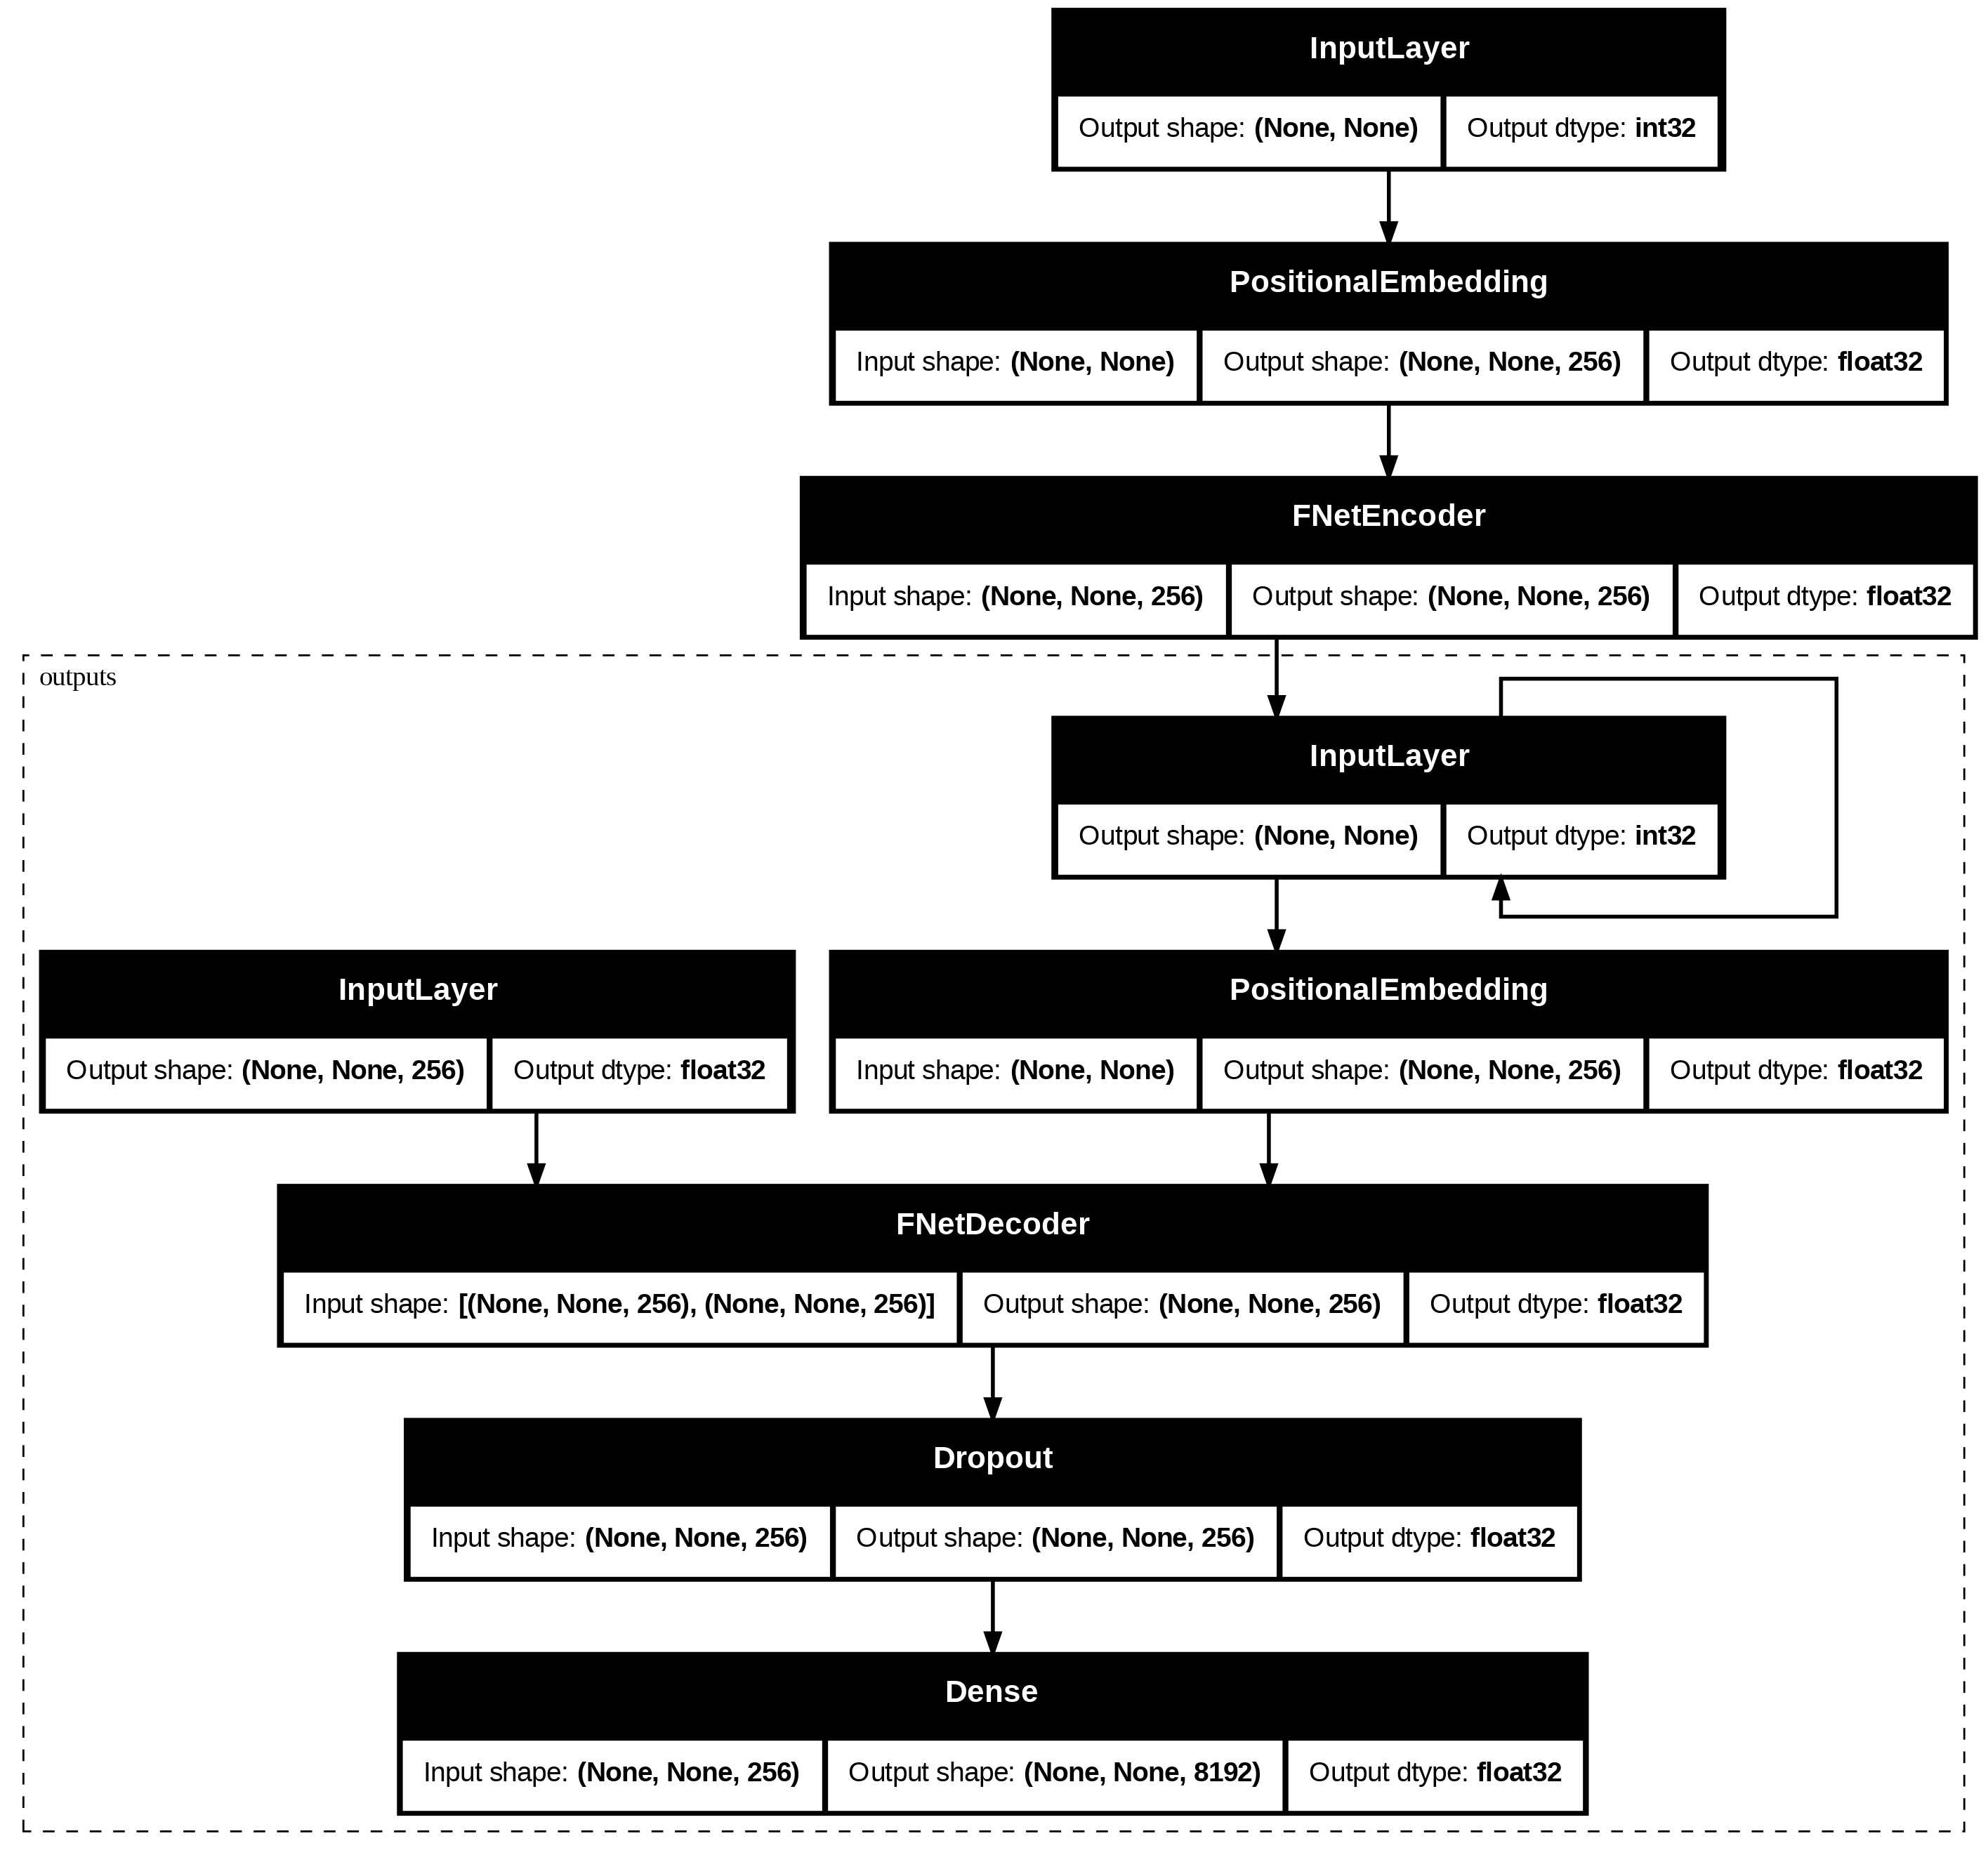

In [39]:
keras.utils.plot_model(fnet, show_shapes=True, show_dtype=True, expand_nested=True)